<a href="https://colab.research.google.com/github/Zeos-ctrl/MicroprojectPXT992/blob/main/GWBModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Read numpy array
data = np.load('/content/drive/MyDrive/csg_strain_data.npy')
params = np.load('/content/drive/MyDrive/csg_param_data.npy')
print(data.shape)
print(params.shape)


(3000, 3, 1024)
(3000, 5)


0.2826382285968293
382.29511064820565
56.0
0.029296875
116.0


<Figure size 1200x600 with 0 Axes>

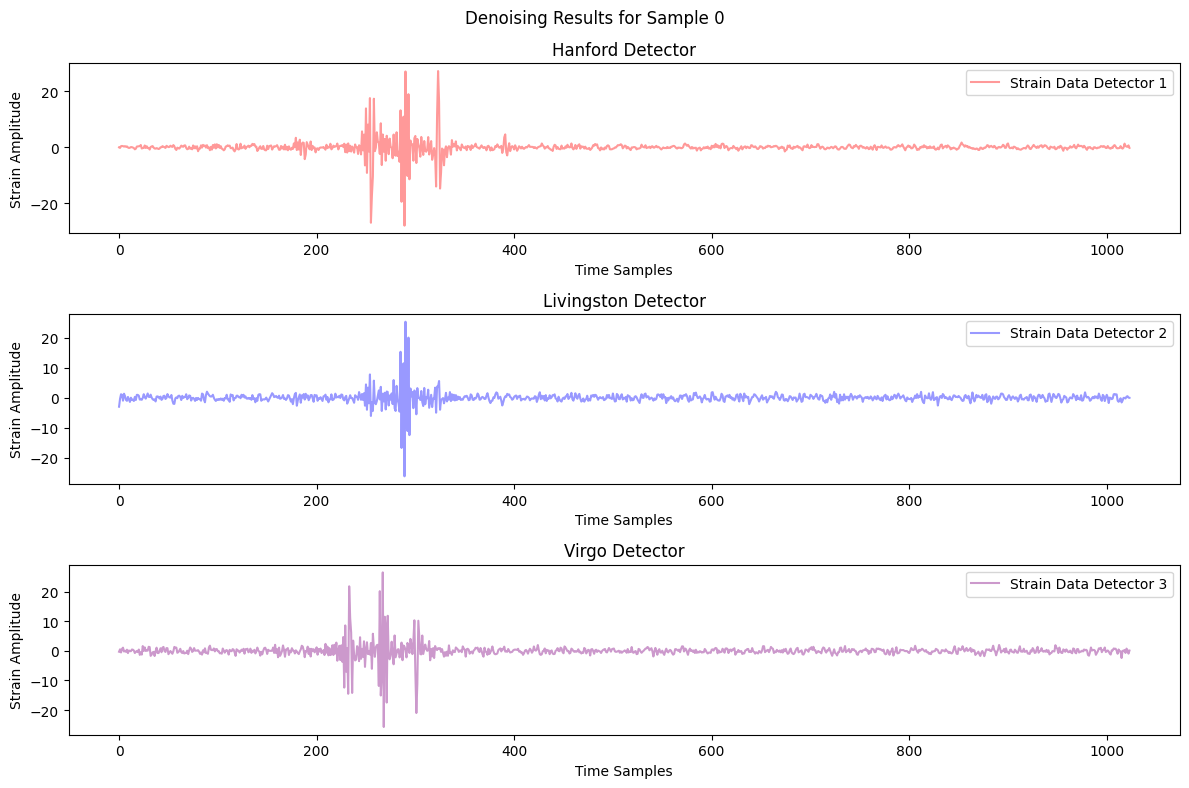

In [2]:
time = np.linspace(0, 1024, 1024)

sample_idx = 0
plt.figure(figsize=(12, 6))
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
detectors = ['Hanford', 'Livingston', 'Virgo']
col = ["red", "blue", "purple"]
for d in range(3):
    axs[d].plot(data[sample_idx][d], color = f"{col[d]}", label=f'Strain Data Detector {d+1}', alpha=0.4)
    axs[d].legend()
    axs[d].set_title(f'{detectors[d]} Detector')
    axs[d].set_xlabel("Time Samples")
    axs[d].set_ylabel("Strain Amplitude")

print(params[sample_idx][0])
print(params[sample_idx][1])
print(params[sample_idx][2])
print(params[sample_idx][3])
print(params[sample_idx][4])
plt.suptitle(f"Denoising Results for Sample {sample_idx}")
plt.tight_layout()
plt.show()

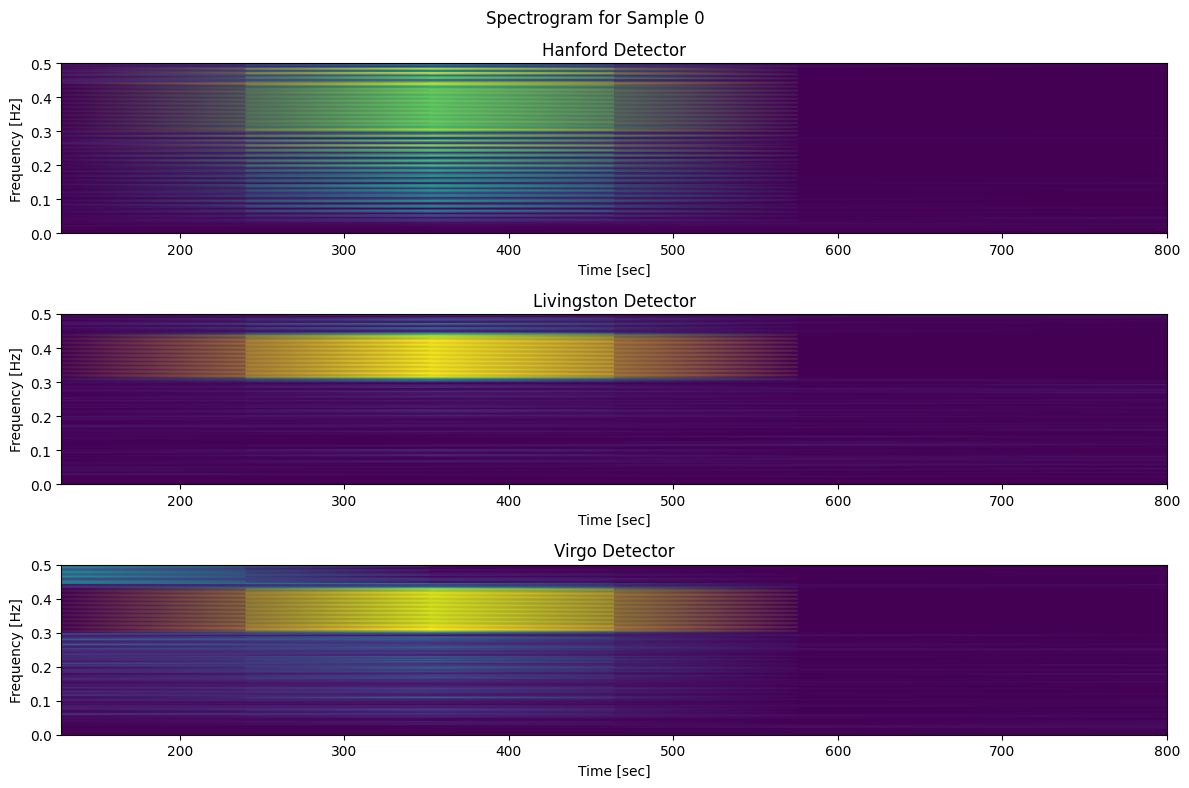

In [3]:
# Convert waveform to time frequency domain
from scipy.signal import spectrogram

fig, axs = plt.subplots(3, 1, figsize=(12, 8))
for d in range(3):
    f, t, Sxx = spectrogram(data[sample_idx][d])
    axs[d].pcolormesh(t, f, Sxx, shading='gouraud')
    axs[d].set_ylabel('Frequency [Hz]')
    axs[d].set_xlabel('Time [sec]')
    axs[d].set_title(f'{detectors[d]} Detector')

plt.suptitle(f'Spectrogram for Sample {sample_idx}')
plt.tight_layout()
plt.show()

There are 4 different models at the moment:

- CNN with standard transformer encoder block.It uses a standard transformer design that combines several important components: multi-head self-attention, shortcuts between layers, and a feed-forward network. With multiple attention heads, the model can recognize different kinds of relationships and patterns in the features it gets from the CNN at the same time. The shortcuts and layer adjustments help make the training smoother, making sure the original CNN features and the new attention-based features work well together.

- CNN with positional encoding. The regular transformer block includes specific information about the position of the input data. Because self-attention methods don't automatically recognize the order of the data, adding positional information helps keep the sequence intact.

- CNN with a simplified, single head attention block. This makes transformer block simpler by using just one attention head, but it increases the size of the key to ensure the model can still understand important details. Fewer attention heads mean the model is less complicated and has fewer parts, which is helpful when there's not a lot of training data or when we want to avoid overfitting.

- And a standard ResNET model to compare against. In many survey papers, ResNET models have been found to be the best for time series analysis.

In [4]:
# --- Project features to transformer dimension ---
def build_transformer_input(x_weighted, units=256):
    return layers.Dense(units, activation='relu')(x_weighted)

# --- Transformer Block: Standard Encoder ---
def transformer_block_v1(x, num_heads=4, key_dim=64, ff_dim=256, dropout_rate=0.1):
    # Pre-Normalization + Multi-Head Attention with Residual Connection
    x_norm = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout_rate)(x_norm, x_norm)
    x = layers.Add()([x, attn_output])

    # Pre-Normalization + Feed-Forward Network with Residual Connection
    x_norm = layers.LayerNormalization()(x)
    ffn_output = layers.Dense(ff_dim, activation='relu')(x_norm)
    ffn_output = layers.Dense(x.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    x = layers.Add()([x, ffn_output])
    return x

# --- Transformer Block: Simplified (Single-Head) ---
def transformer_block_v3(x, key_dim=256, ff_dim=256, dropout_rate=0.1):
    x_norm = layers.LayerNormalization()(x)
    # Single-head attention instead of multi-head
    attn_output = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, dropout=dropout_rate)(x_norm, x_norm)
    x = layers.Add()([x, attn_output])

    x_norm = layers.LayerNormalization()(x)
    ffn_output = layers.Dense(ff_dim, activation='relu')(x_norm)
    ffn_output = layers.Dense(x.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    x = layers.Add()([x, ffn_output])
    return x


# --- Weighted Loss Function ---
def weighted_mse(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Compute the squared errors
        error = tf.square(y_true - y_pred)

        # Multiply each error by its corresponding weight
        weighted_error = error * weights

        # Return the mean over all outputs and samples
        return tf.reduce_mean(weighted_error)

    return loss

# --- Positional Encoding ---
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos_encoding = self.get_positional_encoding(seq_len, self.d_model)
        return x + pos_encoding

    def get_positional_encoding(self, seq_len, d_model):
        # Create a tensor of positions with shape (seq_len, 1)
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        # Create a tensor of dimension indices with shape (1, d_model)
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]

        # Use a float constant for 10000
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates

        # Apply sine to even indices and cosine to odd indices
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        # Interleave sines and cosines to form the positional encoding of shape (seq_len, d_model)
        # Here we stack along a new last axis and then reshape.
        pos_encoding = tf.reshape(tf.stack([sines, cosines], axis=-1), [seq_len, d_model])
        return pos_encoding

In [5]:
# Define loss functions for each output (using MSE here)
losses = {
    'param1': 'mse', # Central time
    'param2': 'mse', # Central Frequency
    'param3': 'mse', # Bandwidth
    'param4': 'mse', # Duration
    'param5': 'mse'  # SNR
}

# Define loss weights for each output
loss_weights = {
    'param1': 1.0,
    'param2': 1.0,
    'param3': 1.5,
    'param4': 2.0,
    'param5': 1.0
}

In [6]:
# Transpose X to match Keras Conv1D expected input shape: (samples, time steps, channels)
X = np.transpose(data, (0, 2, 1))

# Split data (70-20-10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, params, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled   = scaler.transform(y_val)
y_test_scaled  = scaler.transform(y_test)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

# Define the model using the Functional API
inputs = keras.Input(shape=(1024, 3))
x = layers.Conv1D(36, kernel_size=7, activation='relu')(inputs)

# ResNet Block 1
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 2
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 3
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# Class Activation Map (CAM) preserving the temporal dimension.
cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
x_weighted = layers.Multiply()([x, cam_output])
x_pooled = layers.GlobalAveragePooling1D()(x_weighted)

# Fully Connected Layers for regression
x_fc = layers.Dense(256, activation='relu')(x_pooled)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(128, activation='relu')(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(64, activation='relu')(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)

# Create 5 separate outputs
output1 = layers.Dense(1, activation='linear', name='param1')(x_fc)
output2 = layers.Dense(1, activation='linear', name='param2')(x_fc)
output3 = layers.Dense(1, activation='linear', name='param3')(x_fc)
output4 = layers.Dense(1, activation='linear', name='param4')(x_fc)
output5 = layers.Dense(1, activation='linear', name='param5')(x_fc)

model_v0 = keras.Model(inputs, [output1, output2, output3, output4, output5])
model_v0.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'param1': ['mae', 'R2Score'],
        'param2': ['mae', 'R2Score'],
        'param3': ['mae', 'R2Score'],
        'param4': ['mae', 'R2Score'],
        'param5': ['mae', 'R2Score']
    }
)

model_v0.summary()

history_model_v0 = model_v0.fit(
    X_train,
    {
        'param1': y_train_scaled[:, 0],
        'param2': y_train_scaled[:, 1],
        'param3': y_train_scaled[:, 2],
        'param4': y_train_scaled[:, 3],
        'param5': y_train_scaled[:, 4]
    },
    validation_data=(
        X_val,
        {
            'param1': y_val_scaled[:, 0],
            'param2': y_val_scaled[:, 1],
            'param3': y_val_scaled[:, 2],
            'param4': y_val_scaled[:, 3],
            'param5': y_val_scaled[:, 4]
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_cb, checkpoint_cb]
)

results = model_v0.evaluate(
    X_test,
    {
        'param1': y_test_scaled[:, 0],
        'param2': y_test_scaled[:, 1],
        'param3': y_test_scaled[:, 2],
        'param4': y_test_scaled[:, 3],
        'param5': y_test_scaled[:, 4]
    }
)

total_loss = results[0]
test_mae = results[1]
test_r2score = results[2]

print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")
print(f"Total Loss: {total_loss:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1024, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1018, 36)       │            792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 1018, 42)       │          4,578 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 1018, 36)       │          4,572 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1018, 36)       │              0 │ conv1d_2[0][0],        │
│                           │                        │                │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 1018, 36)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 509, 36)        │              0 │ re_lu[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 509, 36)        │            144 │ max_pooling1d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 509, 42)        │          4,578 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 509, 36)        │          4,572 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 509, 36)        │              0 │ conv1d_4[0][0],        │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 509, 36)        │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 254, 36)        │              0 │ re_lu_1[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 254, 36)        │            144 │ max_pooling1d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 254, 42)        │          4,578 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 254, 36)        │          4,572 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)          

 Total params: 79,660 (311.17 KB)

 Trainable params: 79,444 (310.33 KB)

 Non-trainable params: 216 (864.00 B)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - loss: 0.6817 - param1_R2Score: -1.2389 - param1_loss: 0.1444 - param1_mae: 0.3074 - param2_R2Score: -1.6447 - param2_loss: 0.2223 - param2_mae: 0.3844 - param3_R2Score: -0.7250 - param3_loss: 0.0565 - param3_mae: 0.1722 - param4_R2Score: -0.9203 - param4_loss: 0.0343 - param4_mae: 0.1302 - param5_R2Score: -0.9851 - param5_loss: 0.1614 - param5_mae: 0.3144 - val_loss: 0.4004 - val_param1_R2Score: -0.5618 - val_param1_loss: 0.1022 - val_param1_mae: 0.2602 - val_param2_R2Score: -0.3585 - val_param2_loss: 0.1132 - val_param2_mae: 0.2824 - val_param3_R2Score: -0.2512 - val_param3_loss: 0.0400 - val_param3_mae: 0.1328 - val_param4_R2Score: -0.0702 - val_param4_loss: 0.0223 - val_param4_mae: 0.0810 - val_param5_R2Score: 0.0497 - val_param5_loss: 0.0797 - val_param5_mae: 0.2373
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3445 - param1_R2Score: -0.4354 - param1_loss: 0.0984 - param1_mae: 0.2614 - param2_R2Score: -0.0817 -

In [7]:
def build_base_model():
    inputs = keras.Input(shape=(1024, 3))
    # --- CNN Front-End ---
    x = layers.Conv1D(36, kernel_size=7, activation='relu')(inputs)

    # ResNet Block 1
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 2
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 3
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Class Activation Map (CAM) preserving the temporal dimension.
    cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
    x_weighted = layers.Multiply()([x, cam_output])
    x_pooled = layers.GlobalAveragePooling1D()(x_weighted)

    return inputs, x_pooled

def build_single_param_model():
    inputs, base_features = build_base_model()

    x = layers.Dense(256, activation='relu')(base_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Single output for one parameter.
    output = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs, output)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'R2Score']
    )
    return model

ensemble_models = {}  # dictionary to store models
histories = {}

for i in range(5):
    param_name = f"param{i+1}"
    print(f"Training model for {param_name}...")

    # Build the model for this parameter.
    model_x = build_single_param_model()

    # Create a checkpoint callback for this model.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"best_model_{param_name}.keras",
        monitor="val_loss",
        save_best_only=True
    )

    # Train the model.
    history = model_x.fit(
        X_train,
        y_train_scaled[:, i],
        validation_data=(X_val, y_val_scaled[:, i]),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping_cb, checkpoint_cb]
    )

    ensemble_models[param_name] = model_x
    histories[param_name] = history


Training model for param1...
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - R2Score: -0.9616 - loss: 0.1307 - mae: 0.2939 - val_R2Score: -0.1041 - val_loss: 0.0723 - val_mae: 0.2271
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - R2Score: -0.1229 - loss: 0.0741 - mae: 0.2264 - val_R2Score: -0.1110 - val_loss: 0.0727 - val_mae: 0.2277
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - R2Score: -0.0744 - loss: 0.0739 - mae: 0.2285 - val_R2Score: -0.1637 - val_loss: 0.0762 - val_mae: 0.2309
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - R2Score: -0.0212 - loss: 0.0681 - mae: 0.2177 - val_R2Score: -0.1475 - val_loss: 0.0751 - val_mae: 0.2289
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - R2Score: 0.1922 - loss: 0.0574 - mae: 0.1956 - val_R2Score: -0.6093 - val_loss: 0.1054 - val_mae: 0.2656
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - R2Score: 0.2911 - loss: 0.0465 - mae: 0.1704 - val_R2Score: -0.5356 - val_loss: 0.1005 - val_mae: 0.2621
Training mo

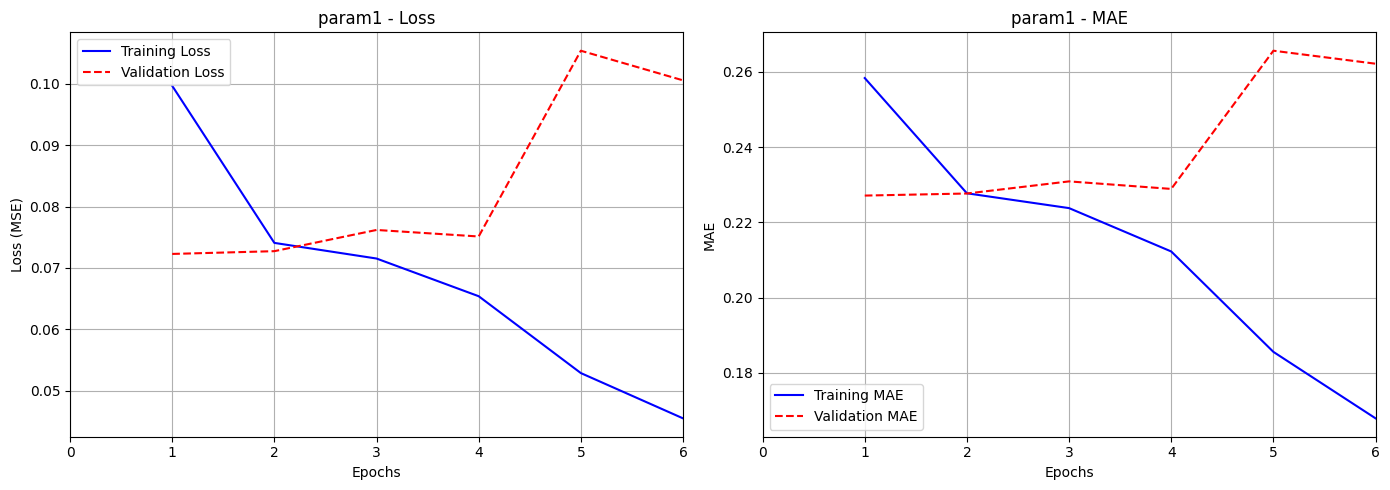

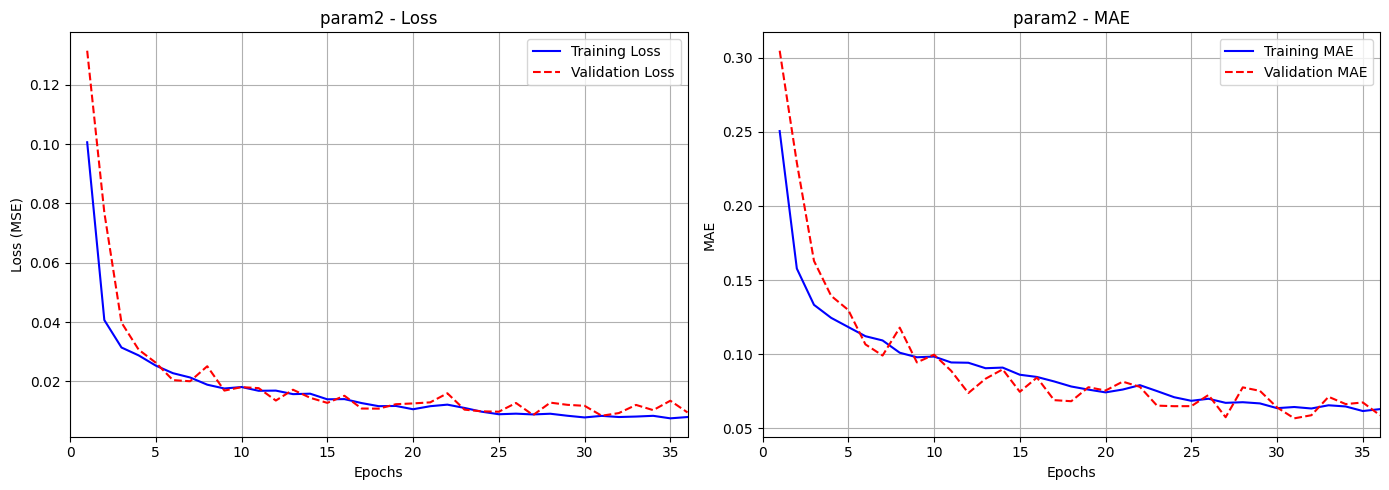

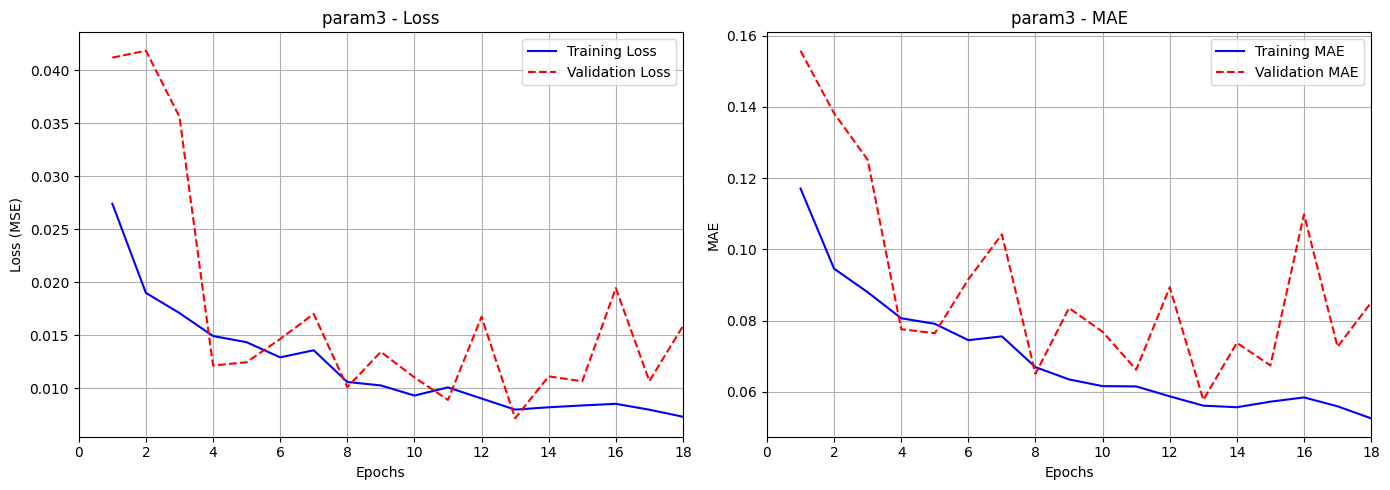

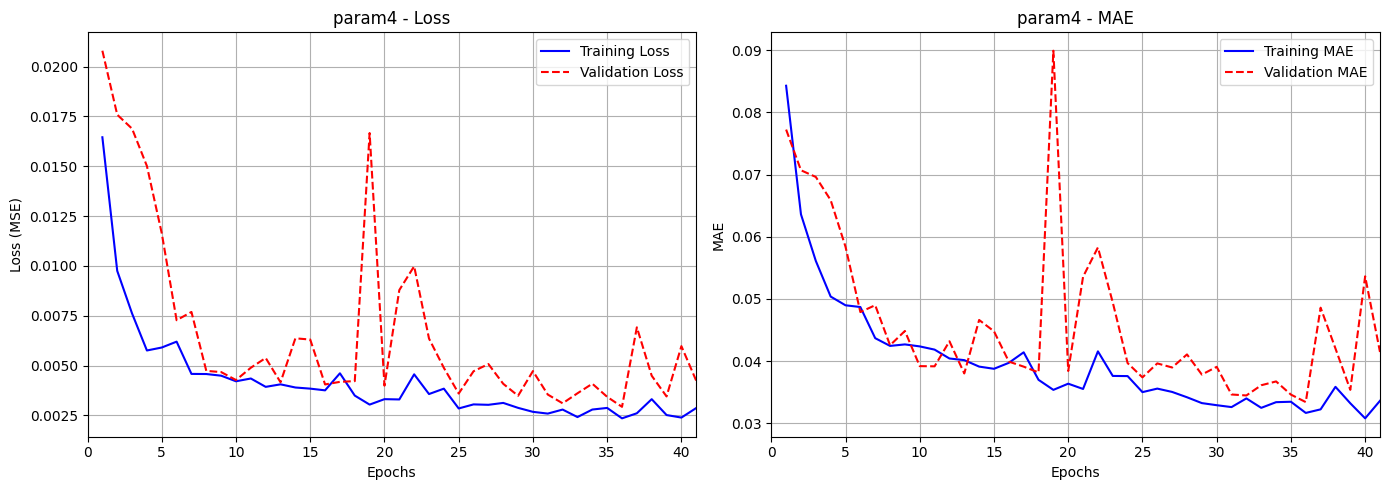

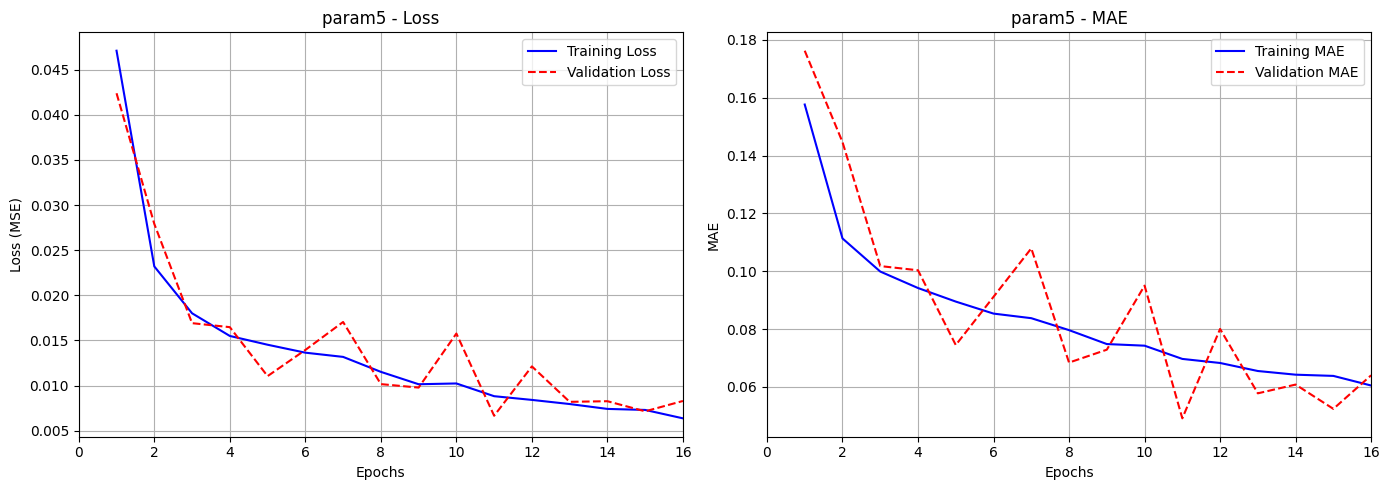

In [8]:
for param_name, history in histories.items():
    h = history.history  # This is a dictionary of metric names to lists of values per epoch.
    epochs = range(1, len(h['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Training and Validation Loss (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, h['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, h['val_loss'], 'r--', label='Validation Loss')
    plt.title(f"{param_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.grid(True)
    plt.xlim([0, max(epochs)])
    plt.legend()

    # Plot Training and Validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, h['mae'], 'b-', label='Training MAE')
    plt.plot(epochs, h['val_mae'], 'r--', label='Validation MAE')
    plt.title(f"{param_name} - MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.xlim([0, max(epochs)])
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
checkpoint_cb_1 = keras.callbacks.ModelCheckpoint("best_model_1.keras", save_best_only=True)

# Define the model input
inputs = keras.Input(shape=(1024, 3))

# CNN Front-End
x = layers.Conv1D(36, kernel_size=7, activation='relu')(inputs)

# ResNet Block 1
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 2
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 3
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# Class Activation Map (CAM) preserving the temporal dimension.
cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
x_weighted = layers.Multiply()([x, cam_output])

# Project to desired transformer dimension
x_transformer_input = build_transformer_input(x_weighted, units=256)

# Apply the standard transformer block (multi-head attention)
x_transformer = transformer_block_v1(x_transformer_input, num_heads=4, key_dim=64, ff_dim=256, dropout_rate=0.1)

# Collapse the time dimension
x_pooled = layers.GlobalAveragePooling1D()(x_transformer)

# Fully-connected layers for regression
x_fc = layers.Dense(256, activation='relu')(x_pooled)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(128, activation='relu')(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)

# Create 5 separate outputs
output1 = layers.Dense(1, activation='linear', name='param1')(x_fc)
output2 = layers.Dense(1, activation='linear', name='param2')(x_fc)
output3 = layers.Dense(1, activation='linear', name='param3')(x_fc)
output4 = layers.Dense(1, activation='linear', name='param4')(x_fc)
output5 = layers.Dense(1, activation='linear', name='param5')(x_fc)

model_v1 = keras.Model(inputs, [output1, output2, output3, output4, output5])
model_v1.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'param1': ['mae', 'R2Score'],
        'param2': ['mae', 'R2Score'],
        'param3': ['mae', 'R2Score'],
        'param4': ['mae', 'R2Score'],
        'param5': ['mae', 'R2Score']
    }
)

model_v1.summary()

history_model_v1 = model_v1.fit(
    X_train,
    {
        'param1': y_train_scaled[:, 0],
        'param2': y_train_scaled[:, 1],
        'param3': y_train_scaled[:, 2],
        'param4': y_train_scaled[:, 3],
        'param5': y_train_scaled[:, 4]
    },
    validation_data=(
        X_val,
        {
            'param1': y_val_scaled[:, 0],
            'param2': y_val_scaled[:, 1],
            'param3': y_val_scaled[:, 2],
            'param4': y_val_scaled[:, 3],
            'param5': y_val_scaled[:, 4]
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_cb, checkpoint_cb]
)

rresults = model_v1.evaluate(
    X_test,
    {
        'param1': y_test_scaled[:, 0],
        'param2': y_test_scaled[:, 1],
        'param3': y_test_scaled[:, 2],
        'param4': y_test_scaled[:, 3],
        'param5': y_test_scaled[:, 4]
    }
)

total_loss = results[0]
test_mae = results[1]
test_r2score = results[2]

print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")
print(f"Total Loss: {total_loss:.4f}")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1024, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_42 (Conv1D)        │ (None, 1018, 36)       │            792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_43 (Conv1D)        │ (None, 1018, 42)       │          4,578 │ conv1d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_44 (Conv1D)        │ (None, 1018, 36)       │          4,572 │ conv1d_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 1018, 36)       │              0 │ conv1d_44[0][0],       │
│                           │                        │                │ conv1d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 1018, 36)       │              0 │ add_18[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_18          │ (None, 509, 36)        │              0 │ re_lu_18[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 509, 36)        │            144 │ max_pooling1d_18[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_45 (Conv1D)        │ (None, 509, 42)        │          4,578 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_46 (Conv1D)        │ (None, 509, 36)        │          4,572 │ conv1d_45[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 509, 36)        │              0 │ conv1d_46[0][0],       │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 509, 36)        │              0 │ add_19[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_19          │ (None, 254, 36)        │              0 │ re_lu_19[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 254, 36)        │            144 │ max_pooling1d_19[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_47 (Conv1D)        │ (None, 254, 42)        │          4,578 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_48 (Conv1D)        │ (None, 254, 36)        │          4,572 │ conv1d_47[0][0]        │
├──────────────────────

 Total params: 533,292 (2.03 MB)

 Trainable params: 533,076 (2.03 MB)

 Non-trainable params: 216 (864.00 B)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 214ms/step - loss: 1.2813 - param1_R2Score: -2.1121 - param1_loss: 0.2012 - param1_mae: 0.3489 - param2_R2Score: -2.7131 - param2_loss: 0.3228 - param2_mae: 0.4264 - param3_R2Score: -4.1605 - param3_loss: 0.1537 - param3_mae: 0.2747 - param4_R2Score: -7.1520 - param4_loss: 0.1636 - param4_mae: 0.2778 - param5_R2Score: -1.5261 - param5_loss: 0.1994 - param5_mae: 0.3227 - val_loss: 2.9087 - val_param1_R2Score: -15.0670 - val_param1_loss: 1.0468 - val_param1_mae: 0.7661 - val_param2_R2Score: -2.3180 - val_param2_loss: 0.2754 - val_param2_mae: 0.4341 - val_param3_R2Score: -0.4450 - val_param3_loss: 0.0462 - val_param3_mae: 0.1651 - val_param4_R2Score: -1.1738 - val_param4_loss: 0.0456 - val_param4_mae: 0.1620 - val_param5_R2Score: -15.9267 - val_param5_loss: 1.4121 - val_param5_mae: 0.9008
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3444 - param1_R2Score: -0.4475 - param1_loss: 0.0972 - param1_mae: 0.2539 - param2_R2Score: -0.08

In [10]:
checkpoint_cb_2 = keras.callbacks.ModelCheckpoint("best_model_2.keras", save_best_only=True)

# Define the model input
inputs = keras.Input(shape=(1024, 3))

# CNN Front-End
x = layers.Conv1D(36, kernel_size=1, activation='relu')(inputs)

# ResNet Block 1
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 2
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 3
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# Class Activation Map (CAM) preserving the temporal dimension.
cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
x_weighted = layers.Multiply()([x, cam_output])

# Project to transformer dimension
x_transformer_input = build_transformer_input(x_weighted, units=256)

# Add positional encoding to preserve sequence order
x_transformer_input = PositionalEncoding(d_model=256)(x_transformer_input)

# Apply the same transformer block as Variation 1
x_transformer = transformer_block_v1(x_transformer_input, num_heads=4, key_dim=64, ff_dim=256, dropout_rate=0.1)

# Global pooling and fully connected layers
x_pooled = layers.GlobalAveragePooling1D()(x_transformer)
x_fc = layers.Dense(256, activation='relu')(x_pooled)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(128, activation='relu')(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)

# Create 5 separate outputs
output1 = layers.Dense(1, activation='linear', name='param1')(x_fc)
output2 = layers.Dense(1, activation='linear', name='param2')(x_fc)
output3 = layers.Dense(1, activation='linear', name='param3')(x_fc)
output4 = layers.Dense(1, activation='linear', name='param4')(x_fc)
output5 = layers.Dense(1, activation='linear', name='param5')(x_fc)

model_v2 = keras.Model(inputs, [output1, output2, output3, output4, output5])
model_v2.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'param1': ['mae', 'R2Score'],
        'param2': ['mae', 'R2Score'],
        'param3': ['mae', 'R2Score'],
        'param4': ['mae', 'R2Score'],
        'param5': ['mae', 'R2Score']
    }
)

model_v2.summary()

history_model_v2 = model_v2.fit(
    X_train,
    {
        'param1': y_train_scaled[:, 0],
        'param2': y_train_scaled[:, 1],
        'param3': y_train_scaled[:, 2],
        'param4': y_train_scaled[:, 3],
        'param5': y_train_scaled[:, 4]
    },
    validation_data=(
        X_val,
        {
            'param1': y_val_scaled[:, 0],
            'param2': y_val_scaled[:, 1],
            'param3': y_val_scaled[:, 2],
            'param4': y_val_scaled[:, 3],
            'param5': y_val_scaled[:, 4]
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_cb, checkpoint_cb]
)

results = model_v2.evaluate(
    X_test,
    {
        'param1': y_test_scaled[:, 0],
        'param2': y_test_scaled[:, 1],
        'param3': y_test_scaled[:, 2],
        'param4': y_test_scaled[:, 3],
        'param5': y_test_scaled[:, 4]
    }
)

total_loss = results[0]
test_mae = results[1]
test_r2score = results[2]

print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")
print(f"Total Loss: {total_loss:.4f}")

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 1024, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_49 (Conv1D)        │ (None, 1024, 36)       │            144 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_50 (Conv1D)        │ (None, 1024, 42)       │          4,578 │ conv1d_49[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)        │ (None, 1024, 36)       │          4,572 │ conv1d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_23 (Add)              │ (None, 1024, 36)       │              0 │ conv1d_51[0][0],       │
│                           │                        │                │ conv1d_49[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_21 (ReLU)           │ (None, 1024, 36)       │              0 │ add_23[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_21          │ (None, 512, 36)        │              0 │ re_lu_21[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 512, 36)        │            144 │ max_pooling1d_21[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_52 (Conv1D)        │ (None, 512, 42)        │          4,578 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_53 (Conv1D)        │ (None, 512, 36)        │          4,572 │ conv1d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 512, 36)        │              0 │ conv1d_53[0][0],       │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_22 (ReLU)           │ (None, 512, 36)        │              0 │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_22          │ (None, 256, 36)        │              0 │ re_lu_22[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 256, 36)        │            144 │ max_pooling1d_22[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_54 (Conv1D)        │ (None, 256, 42)        │          4,578 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_55 (Conv1D)        │ (None, 256, 36)        │          4,572 │ conv1d_54[0][0]        │
├──────────────────────

 Total params: 532,644 (2.03 MB)

 Trainable params: 532,428 (2.03 MB)

 Non-trainable params: 216 (864.00 B)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - loss: 2.4111 - param1_R2Score: -5.2251 - param1_loss: 0.4083 - param1_mae: 0.4570 - param2_R2Score: -2.7693 - param2_loss: 0.3145 - param2_mae: 0.4252 - param3_R2Score: -14.8655 - param3_loss: 0.4878 - param3_mae: 0.4097 - param4_R2Score: -14.3488 - param4_loss: 0.2932 - param4_mae: 0.3602 - param5_R2Score: -3.7286 - param5_loss: 0.3699 - param5_mae: 0.4546 - val_loss: 0.3800 - val_param1_R2Score: -0.2265 - val_param1_loss: 0.0802 - val_param1_mae: 0.2362 - val_param2_R2Score: -0.4134 - val_param2_loss: 0.1177 - val_param2_mae: 0.2926 - val_param3_R2Score: -0.0125 - val_param3_loss: 0.0323 - val_param3_mae: 0.1302 - val_param4_R2Score: -0.0649 - val_param4_loss: 0.0222 - val_param4_mae: 0.0805 - val_param5_R2Score: -0.0536 - val_param5_loss: 0.0884 - val_param5_mae: 0.2595
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4680 - param1_R2Score: -0.6251 - param1_loss: 0.1095 - param1_mae: 0.2697 - param2_R2Score: -0.428

In [15]:
checkpoint_cb_3 = keras.callbacks.ModelCheckpoint("best_model_3.keras", save_best_only=True)

# Define the model input
inputs = keras.Input(shape=(1024, 3))

# CNN Front-End
x = layers.Conv1D(36, kernel_size=1, activation='relu')(inputs)

# ResNet Block 1
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 2
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 3
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# Class Activation Map (CAM) preserving the temporal dimension.
cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
x_weighted = layers.Multiply()([x, cam_output])

# Project features for transformer input
x_transformer_input = build_transformer_input(x_weighted, units=256)

# Apply the simplified transformer block (single-head attention)
x_transformer = transformer_block_v3(x_transformer_input, key_dim=256, ff_dim=256, dropout_rate=0.1)

# Global pooling and fully-connected layers
x_pooled = layers.GlobalAveragePooling1D()(x_transformer)
x_fc = layers.Dense(256, activation='relu')(x_pooled)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(128, activation='relu')(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)

# Create 5 separate outputs
output1 = layers.Dense(1, activation='linear', name='param1')(x_fc)
output2 = layers.Dense(1, activation='linear', name='param2')(x_fc)
output3 = layers.Dense(1, activation='linear', name='param3')(x_fc)
output4 = layers.Dense(1, activation='linear', name='param4')(x_fc)
output5 = layers.Dense(1, activation='linear', name='param5')(x_fc)

model_v3 = keras.Model(inputs, [output1, output2, output3, output4, output5])
model_v3.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'param1': ['mae', 'R2Score'],
        'param2': ['mae', 'R2Score'],
        'param3': ['mae', 'R2Score'],
        'param4': ['mae', 'R2Score'],
        'param5': ['mae', 'R2Score']
    }
)

model_v3.summary()

history_model_v3 = model_v3.fit(
    X_train,
    {
        'param1': y_train_scaled[:, 0],
        'param2': y_train_scaled[:, 1],
        'param3': y_train_scaled[:, 2],
        'param4': y_train_scaled[:, 3],
        'param5': y_train_scaled[:, 4]
    },
    validation_data=(
        X_val,
        {
            'param1': y_val_scaled[:, 0],
            'param2': y_val_scaled[:, 1],
            'param3': y_val_scaled[:, 2],
            'param4': y_val_scaled[:, 3],
            'param5': y_val_scaled[:, 4]
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_cb, checkpoint_cb]
)

results = model_v3.evaluate(
    X_test,
    {
        'param1': y_test_scaled[:, 0],
        'param2': y_test_scaled[:, 1],
        'param3': y_test_scaled[:, 2],
        'param4': y_test_scaled[:, 3],
        'param5': y_test_scaled[:, 4]
    }
)

total_loss = results[0]
test_mae = results[1]
test_r2score = results[2]

print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")
print(f"Total Loss: {total_loss:.4f}")

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 1024, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_56 (Conv1D)        │ (None, 1024, 36)       │            144 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_57 (Conv1D)        │ (None, 1024, 42)       │          4,578 │ conv1d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_58 (Conv1D)        │ (None, 1024, 36)       │          4,572 │ conv1d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_28 (Add)              │ (None, 1024, 36)       │              0 │ conv1d_58[0][0],       │
│                           │                        │                │ conv1d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_24 (ReLU)           │ (None, 1024, 36)       │              0 │ add_28[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_24          │ (None, 512, 36)        │              0 │ re_lu_24[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 512, 36)        │            144 │ max_pooling1d_24[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_59 (Conv1D)        │ (None, 512, 42)        │          4,578 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_60 (Conv1D)        │ (None, 512, 36)        │          4,572 │ conv1d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_29 (Add)              │ (None, 512, 36)        │              0 │ conv1d_60[0][0],       │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_25 (ReLU)           │ (None, 512, 36)        │              0 │ add_29[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_25          │ (None, 256, 36)        │              0 │ re_lu_25[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 256, 36)        │            144 │ max_pooling1d_25[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_61 (Conv1D)        │ (None, 256, 42)        │          4,578 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_62 (Conv1D)        │ (None, 256, 36)        │          4,572 │ conv1d_61[0][0]        │
├──────────────────────

 Total params: 532,644 (2.03 MB)

 Trainable params: 532,428 (2.03 MB)

 Non-trainable params: 216 (864.00 B)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - loss: 1.9987 - param1_R2Score: -5.4227 - param1_loss: 0.4172 - param1_mae: 0.4517 - param2_R2Score: -2.3580 - param2_loss: 0.2882 - param2_mae: 0.4042 - param3_R2Score: -10.8135 - param3_loss: 0.3520 - param3_mae: 0.3884 - param4_R2Score: -13.1846 - param4_loss: 0.2264 - param4_mae: 0.3082 - param5_R2Score: -2.9324 - param5_loss: 0.3124 - param5_mae: 0.3995 - val_loss: 0.6483 - val_param1_R2Score: -0.3100 - val_param1_loss: 0.0859 - val_param1_mae: 0.2407 - val_param2_R2Score: -0.2898 - val_param2_loss: 0.1071 - val_param2_mae: 0.2798 - val_param3_R2Score: 0.0032 - val_param3_loss: 0.0319 - val_param3_mae: 0.1454 - val_param4_R2Score: -0.0182 - val_param4_loss: 0.0212 - val_param4_mae: 0.0953 - val_param5_R2Score: -3.3435 - val_param5_loss: 0.3634 - val_param5_mae: 0.5275
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.4128 - param1_R2Score: -0.6255 - param1_loss: 0.1059 - param1_mae: 0.2645 - param2_R2Score: -0.357

In [12]:
'''
X_resnet = np.transpose(data, (0, 2, 1))  # shape: (3000, 1024, 3)
X_resnet = np.expand_dims(X_resnet, axis=2)  # shape: (3000, 1024, 1, 3)
X_resnet = np.tile(X_resnet, (1, 1, 32, 1))  # Now shape: (3000, 1024, 32, 3), satisfies min size (32x32)

resnet_train, resnet_temp, resnet_y_train, resnet_y_temp = train_test_split(X_resnet, params, test_size=0.3, random_state=42)
resnet_val, resnet_test, resnet_y_val, resnet_y_test = train_test_split(resnet_temp, resnet_y_temp, test_size=1/3, random_state=42)

scaler = MinMaxScaler()
resnet_y_train_scaled = scaler.fit_transform(resnet_y_train)
resnet_y_val_scaled   = scaler.transform(resnet_y_val)
resnet_y_test_scaled  = scaler.transform(resnet_y_test)

resnet = keras.applications.ResNet50(
    include_top=False,
    weights=None,  # Train from scratch
    input_shape=(1024, 32, 3),
    pooling='avg'
)

x = resnet.output

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

output1 = layers.Dense(1, activation='linear', name='param1')(x)
output2 = layers.Dense(1, activation='linear', name='param2')(x)
output3 = layers.Dense(1, activation='linear', name='param3')(x)
output4 = layers.Dense(1, activation='linear', name='param4')(x)
output5 = layers.Dense(1, activation='linear', name='param5')(x)

resnet_model = keras.Model(inputs=resnet.input, outputs=[output1, output2, output3, output4, output5])
resnet_model.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'param1': ['mae', 'R2Score'],
        'param2': ['mae', 'R2Score'],
        'param3': ['mae', 'R2Score'],
        'param4': ['mae', 'R2Score'],
        'param5': ['mae', 'R2Score']
    }
)

resnet_model.summary()

resnet_history = resnet_model.fit(
    resnet_train,
    {
        'param1': resnet_y_train_scaled[:, 0],
        'param2': resnet_y_train_scaled[:, 1],
        'param3': resnet_y_train_scaled[:, 2],
        'param4': resnet_y_train_scaled[:, 3],
        'param5': resnet_y_train_scaled[:, 4]
    },
    validation_data=(
        resnet_val,
        {
            'param1': resnet_y_val_scaled[:, 0],
            'param2': resnet_y_val_scaled[:, 1],
            'param3': resnet_y_val_scaled[:, 2],
            'param4': resnet_y_val_scaled[:, 3],
            'param5': resnet_y_val_scaled[:, 4]
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_cb, checkpoint_cb]
)

results = resnet_model.evaluate(
    resnet_test,
    {
        'param1': resnet_y_test_scaled[:, 0],
        'param2': resnet_y_test_scaled[:, 1],
        'param3': resnet_y_test_scaled[:, 2],
        'param4': resnet_y_test_scaled[:, 3],
        'param5': resnet_y_test_scaled[:, 4]
    }
)

total_loss = results[0]
test_mae = results[1]
test_r2score = results[2]

print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")
print(f"Total Loss: {total_loss:.4f}")
'''

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 1024, 32, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 1030, 38, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 512, 16, 64)    │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 512, 16, 64)    │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 512, 16, 64)    │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 514, 18, 64)    │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 256, 8, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 256, 8, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 256, 8, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 256, 8, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 256, 8, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 256, 8, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 256, 8, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 256, 8, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 256, 8, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 24,092,677 (91.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - loss: 6.3388 - param1_R2Score: -14.6448 - param1_loss: 1.0345 - param1_mae: 0.6494 - param2_R2Score: -9.9059 - param2_loss: 0.9100 - param2_mae: 0.6248 - param3_R2Score: -35.4511 - param3_loss: 1.2525 - param3_mae: 0.5471 - param4_R2Score: -34.0451 - param4_loss: 0.6363 - param4_mae: 0.4327 - param5_R2Score: -14.4135 - param5_loss: 1.2425 - param5_mae: 0.6805 - val_loss: 0.5120 - val_param1_R2Score: -1.1445 - val_param1_loss: 0.1401 - val_param1_mae: 0.3072 - val_param2_R2Score: -0.7069 - val_param2_loss: 0.1422 - val_param2_mae: 0.3158 - val_param3_R2Score: -0.1421 - val_param3_loss: 0.0365 - val_param3_mae: 0.1287 - val_param4_R2Score: -0.2919 - val_param4_loss: 0.0269 - val_param4_mae: 0.1035 - val_param5_R2Score: -0.4305 - val_param5_loss: 0.1202 - val_param5_mae: 0.2967
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - loss: 0.5087 - param1_R2Score: -1.0088 - param1_loss: 0.1296 - param1_mae: 0.2930 - param2_R2Score: -0.5

In [13]:
# Incase of power off load model from memory
#model_v0 = keras.models.load_model("best_model.keras")
#model_v1 = keras.models.load_model("best_model_1.keras")
#model_v2 = keras.models.load_model("best_model_2.keras")
#model_v3 = keras.models.load_model("best_model_3.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


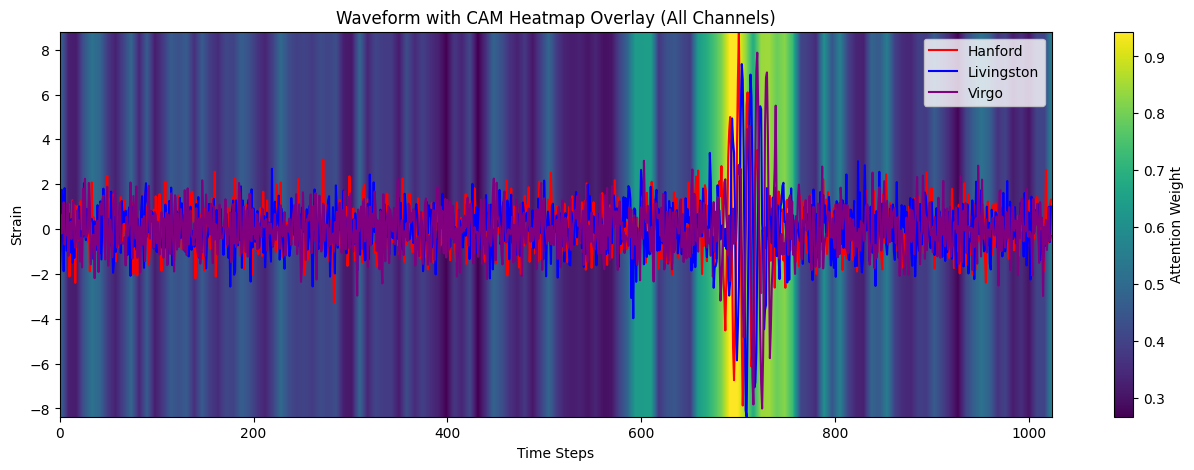

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


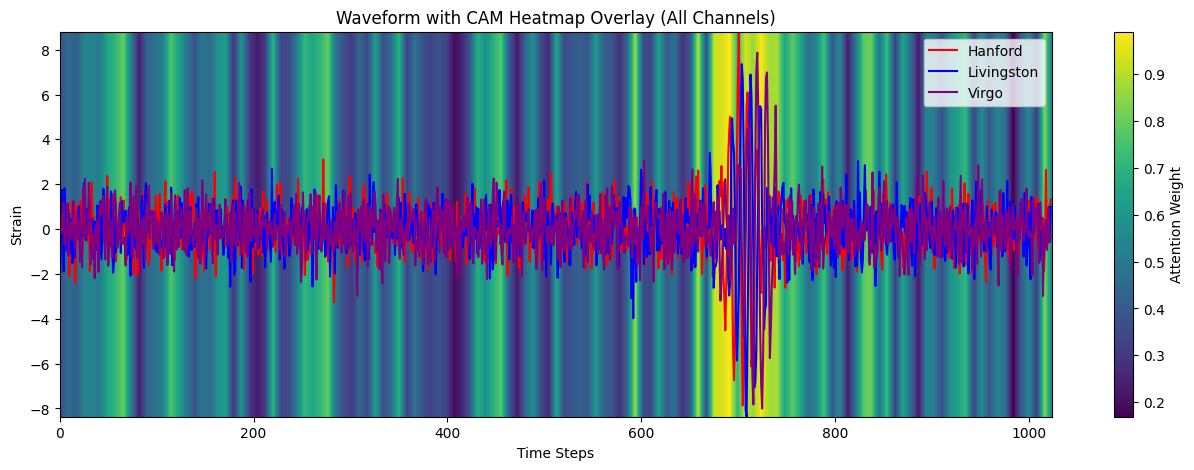

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


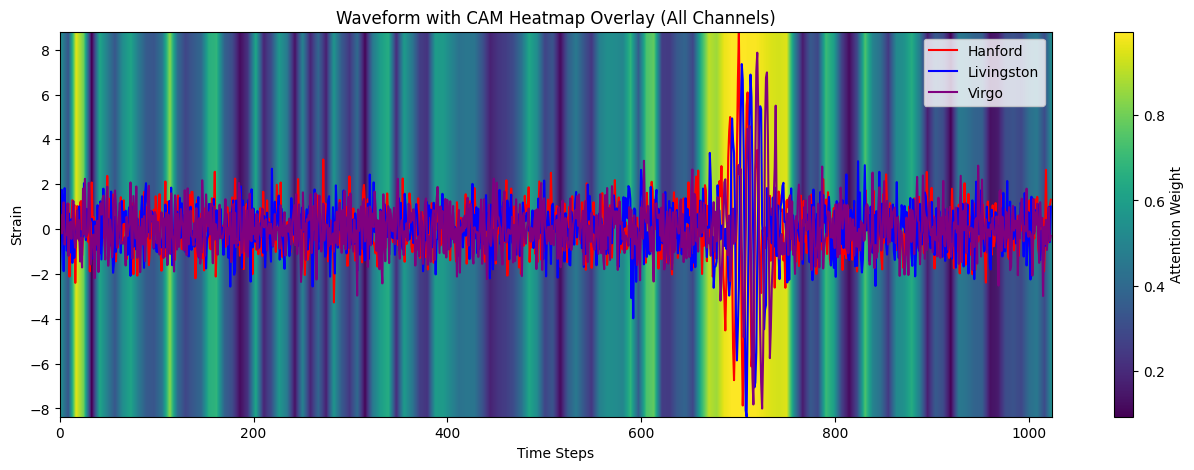

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


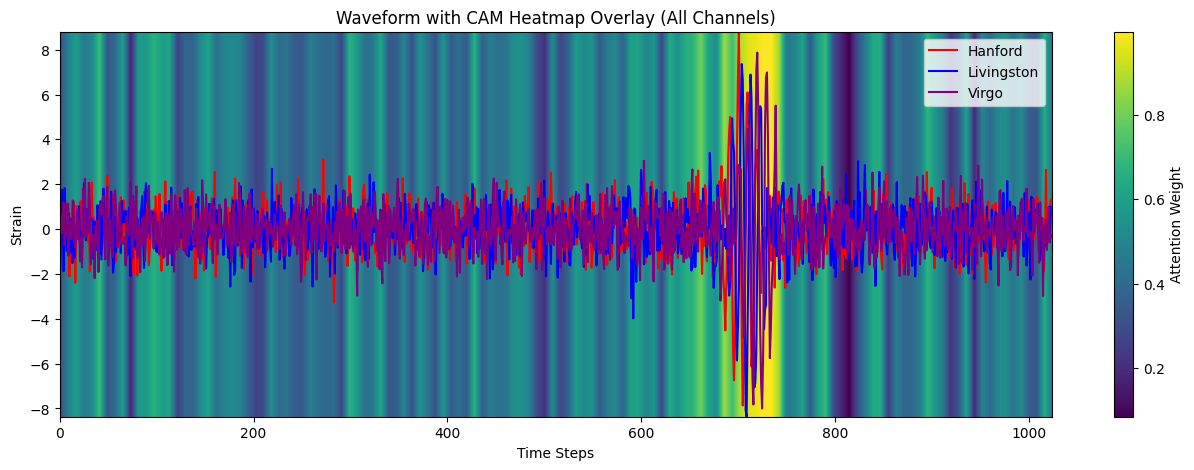

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


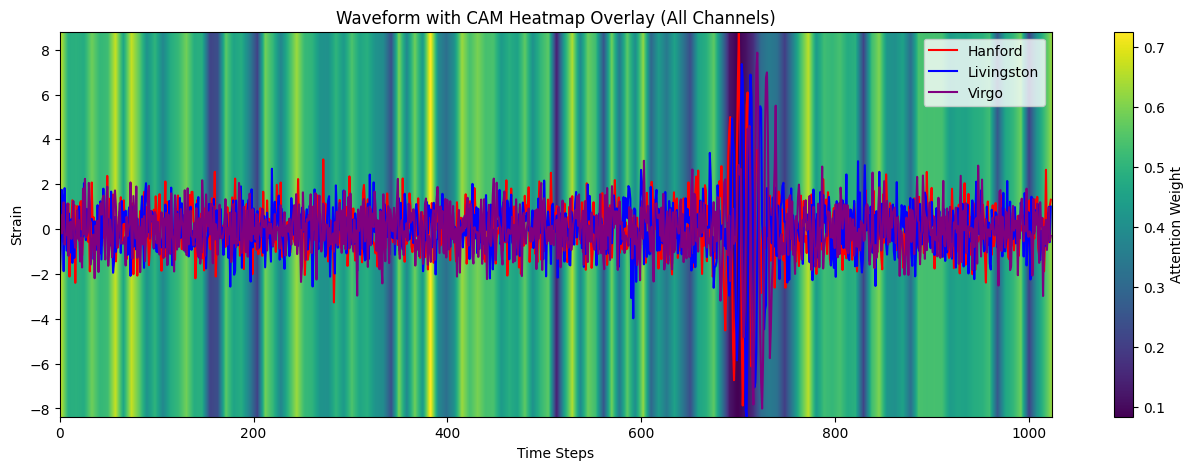

In [16]:
def visualize_cam_all_channels(sample_index, model):
    # Extract the waveform sample
    waveform_sample = X_test[sample_index]

    # Determine overall min and max for y-axis across all channels
    y_min = waveform_sample.min()
    y_max = waveform_sample.max()

    # Build a model that outputs the CAM
    cam_model = keras.Model(inputs=model.input, outputs=model.get_layer('cam_layer').output)

    # Get the CAM output for the sample
    cam_out = cam_model.predict(X_test[[sample_index]])[0]
    cam_out = cam_out.squeeze()

    # Upsample the CAM to match the waveform length
    num_points = 1024
    x_old = np.linspace(0, num_points - 1, num=len(cam_out))
    x_new = np.arange(num_points)
    cam_upsampled = np.interp(x_new, x_old, cam_out)

    # Create a 2D heatmap array by replicating the upsampled CAM
    heatmap = np.tile(cam_upsampled, (10, 1))

    # Lets see what we have
    fig, ax = plt.subplots(figsize=(16, 5))
    x = np.arange(num_points)

    # Plot each channel with a different color
    ax.plot(x, waveform_sample[:, 0], label='Hanford', color='red')
    ax.plot(x, waveform_sample[:, 1], label='Livingston', color='blue')
    ax.plot(x, waveform_sample[:, 2], label='Virgo', color='purple')

    # Overlay the heatmap using imshow
    im = ax.imshow(heatmap, aspect='auto', cmap='viridis', alpha=1,
                   extent=[0, num_points, y_min, y_max],
                   origin='lower')

    # Add a colorbar with a label
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight')

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Strain')
    ax.set_title('Waveform with CAM Heatmap Overlay (All Channels)')
    ax.legend()
    plt.show()

# Think of 5 numbers between 0-300
indexes = np.random.randint(0, 300, 1)
for i in indexes:
    visualize_cam_all_channels(sample_index=i, model=model_v0)
    visualize_cam_all_channels(sample_index=i, model=model_v1)
    visualize_cam_all_channels(sample_index=i, model=model_v2)
    visualize_cam_all_channels(sample_index=i, model=model_v3)
    visualize_cam_all_channels(sample_index=i, model=model_x)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


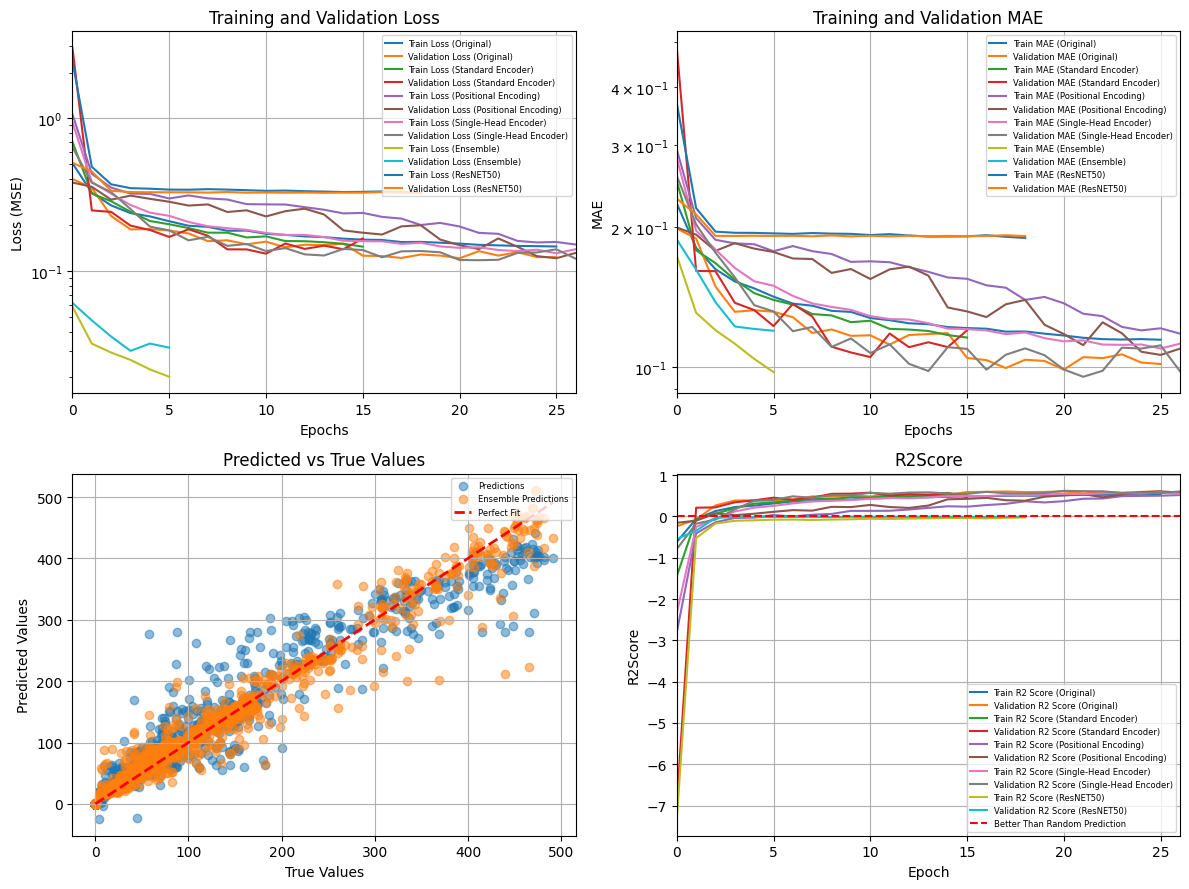

In [31]:
# Generate model predictions
y_pred_scaled = model_v0.predict(X_test)

# Concatenate the predictions for all 5 parameters into a single 2D array
y_pred_scaled = np.concatenate(y_pred_scaled, axis=1)

# Reverse the scaling to get predictions back on the original scale:
y_pred = scaler.inverse_transform(y_pred_scaled)

def ensemble_predict(ensemble_models, X):
    predictions = {}
    for key, model in ensemble_models.items():
        predictions[key] = model.predict(X)

    sorted_keys = sorted(predictions.keys())
    combined = np.hstack([predictions[k] for k in sorted_keys])
    return combined

combined_predictions_scaled = ensemble_predict(ensemble_models, X_test)
combined_predictions = scaler.inverse_transform(combined_predictions_scaled)


# Calculate total stats statistics
def compute_total_stats(history):
    # Define keys for the training and validation metrics.
    train_keys_mae = [f'param{i}_mae' for i in range(1, 6)]
    val_keys_mae   = [f'val_param{i}_mae' for i in range(1, 6)]
    train_keys_r2 = [f'param{i}_R2Score' for i in range(1, 6)]
    val_keys_r2   = [f'val_param{i}_R2Score' for i in range(1, 6)]

    # Compute the mean MAE across outputs for each epoch.
    total_train_mae = np.mean([history[k] for k in train_keys_mae], axis=0)
    total_val_mae   = np.mean([history[k] for k in val_keys_mae], axis=0)
    total_train_r2 = np.mean([history[k] for k in train_keys_r2], axis=0)
    total_val_r2   = np.mean([history[k] for k in val_keys_r2], axis=0)
    return total_train_mae, total_val_mae, total_train_r2, total_val_r2

total_train_mae_v0, total_val_mae_v0, total_train_r2_v0, total_val_r2_v0 = compute_total_stats(history_model_v0.history)
total_train_mae_v1, total_val_mae_v1, total_train_r2_v1, total_val_r2_v1 = compute_total_stats(history_model_v1.history)
total_train_mae_v2, total_val_mae_v2, total_train_r2_v2, total_val_r2_v2 = compute_total_stats(history_model_v2.history)
total_train_mae_v3, total_val_mae_v3, total_train_r2_v3, total_val_r2_v3 = compute_total_stats(history_model_v3.history)
total_train_mae_resnet, total_val_mae_resnet, total_train_r2_resnet, total_val_r2_resnet = compute_total_stats(resnet_history.history)

def compute_ensemble_stats(ensemble_histories):
    # Determine the minimum number of epochs across all histories
    min_epochs = min(len(hist['loss']) for hist in ensemble_histories.values())

    # Initialize lists for each metric, slicing to the minimum epoch count
    train_loss_list, val_loss_list = [], []
    train_mae_list, val_mae_list = [], []

    for hist in ensemble_histories.values():
        train_loss_list.append(np.array(hist['loss'][:min_epochs]))
        val_loss_list.append(np.array(hist['val_loss'][:min_epochs]))
        train_mae_list.append(np.array(hist['mae'][:min_epochs]))
        val_mae_list.append(np.array(hist['val_mae'][:min_epochs]))

    # Stack the lists into arrays of shape (num_models, min_epochs)
    train_loss_arr = np.stack(train_loss_list, axis=0)
    val_loss_arr   = np.stack(val_loss_list, axis=0)
    train_mae_arr  = np.stack(train_mae_list, axis=0)
    val_mae_arr    = np.stack(val_mae_list, axis=0)

    # Compute the average over the models (axis=0)
    avg_train_loss = np.mean(train_loss_arr, axis=0)
    avg_val_loss   = np.mean(val_loss_arr, axis=0)
    avg_train_mae  = np.mean(train_mae_arr, axis=0)
    avg_val_mae    = np.mean(val_mae_arr, axis=0)

    return avg_train_loss, avg_val_loss, avg_train_mae, avg_val_mae

# build a dictionary of history dictionaries.
ensemble_histories = {key: value.history for key, value in histories.items()}
ensemble_train_loss, ensemble_val_loss, ensemble_train_mae, ensemble_val_mae = compute_ensemble_stats(ensemble_histories)

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Loss Curve (Training vs Validation)
axes[0, 0].plot(history_model_v0.history['loss'], label='Train Loss (Original)')
axes[0, 0].plot(history_model_v0.history['val_loss'], label='Validation Loss (Original)')
axes[0, 0].plot(history_model_v1.history['loss'], label='Train Loss (Standard Encoder)')
axes[0, 0].plot(history_model_v1.history['val_loss'], label='Validation Loss (Standard Encoder)')
axes[0, 0].plot(history_model_v2.history['loss'], label=['Train Loss (Positional Encoding)'])
axes[0, 0].plot(history_model_v2.history['val_loss'], label=['Validation Loss (Positional Encoding)'])
axes[0, 0].plot(history_model_v3.history['loss'], label=['Train Loss (Single-Head Encoder)'])
axes[0, 0].plot(history_model_v3.history['val_loss'], label=['Validation Loss (Single-Head Encoder)'])
axes[0, 0].plot(ensemble_train_loss, label='Train Loss (Ensemble)')
axes[0, 0].plot(ensemble_val_loss, label='Validation Loss (Ensemble)')
axes[0, 0].plot(resnet_history.history['loss'], label='Train Loss (ResNET50)')
axes[0, 0].plot(resnet_history.history['val_loss'], label='Validation Loss (ResNET50)')
axes[0, 0].set_xlim([0, len(history_model_v0.history['loss'])])
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend(loc=1, prop={'size': 6})
axes[0, 0].grid(True)

# Mean Absolute Error Regression Statistic
axes[0, 1].plot(total_train_mae_v0, label='Train MAE (Original)')
axes[0, 1].plot(total_val_mae_v0, label='Validation MAE (Original)')
axes[0, 1].plot(total_train_mae_v1, label='Train MAE (Standard Encoder)')
axes[0, 1].plot(total_val_mae_v1, label='Validation MAE (Standard Encoder)')
axes[0, 1].plot(total_train_mae_v2, label=['Train MAE (Positional Encoding)'])
axes[0, 1].plot(total_val_mae_v2, label=['Validation MAE (Positional Encoding)'])
axes[0, 1].plot(total_train_mae_v3, label=['Train MAE (Single-Head Encoder)'])
axes[0, 1].plot(total_val_mae_v3, label=['Validation MAE (Single-Head Encoder)'])
axes[0, 1].plot(ensemble_train_mae, label='Train MAE (Ensemble)')
axes[0, 1].plot(ensemble_val_mae, label='Validation MAE (Ensemble)')
axes[0, 1].plot(total_train_mae_resnet, label='Train MAE (ResNET50)')
axes[0, 1].plot(total_val_mae_resnet, label='Validation MAE (ResNET50)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim([0, len(history_model_v0.history['loss'])])
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Training and Validation MAE')
axes[0, 1].legend(loc=1, prop={'size': 6})
axes[0, 1].grid(True)

# Prediction vs True Values Scatter Plot with Line of Best Fit
axes[1, 0].scatter(y_test, y_pred, alpha=0.5, label="Predictions")
axes[1, 0].scatter(y_test, combined_predictions, alpha=0.5, label="Ensemble Predictions")
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, label="Perfect Fit", color="red")
axes[1, 0].set_xlabel("True Values")
axes[1, 0].set_ylabel("Predicted Values")
axes[1, 0].set_title("Predicted vs True Values")
axes[1, 0].legend(loc=1, prop={'size': 6})
axes[1, 0].grid(True)

# R2Score
axes[1, 1].plot(total_train_r2_v0, label='Train R2 Score (Original)')
axes[1, 1].plot(total_val_r2_v0, label='Validation R2 Score (Original)')
axes[1, 1].plot(total_train_r2_v1, label='Train R2 Score (Standard Encoder)')
axes[1, 1].plot(total_val_r2_v1, label='Validation R2 Score (Standard Encoder)')
axes[1, 1].plot(total_train_r2_v2, label=['Train R2 Score (Positional Encoding)'])
axes[1, 1].plot(total_val_r2_v2, label=['Validation R2 Score (Positional Encoding)'])
axes[1, 1].plot(total_train_r2_v3, label=['Train R2 Score (Single-Head Encoder)'])
axes[1, 1].plot(total_val_r2_v3, label=['Validation R2 Score (Single-Head Encoder)'])
axes[1, 1].plot(total_train_r2_resnet, label='Train R2 Score (ResNET50)')
axes[1, 1].plot(total_val_r2_resnet, label='Validation R2 Score (ResNET50)')
axes[1, 1].axhline(y=0, color='r', linestyle='--', label='Better Than Random Prediction')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("R2Score")
axes[1, 1].set_xlim([0, len(history_model_v0.history['loss'])])
axes[1, 1].set_title("R2Score")
axes[1, 1].legend(loc=4, prop={'size': 6})
axes[1, 1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()